In [54]:
import numpy as np                                      # for dealing with data
from scipy.signal import butter, sosfiltfilt, sosfreqz  # for filtering
import matplotlib.pyplot as plt                         # for plotting
import pandas as pd 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import os
from os import listdir
from os.path import isfile, join, isdir
import pickle
import mne

In [55]:

# Create filtering variables
fs = 200.0     # 200 Hz sampling rate
lowcut = 1.0   # 0.1 Hz is the lowest frequency we will pass
highcut = 40.0 # 30  Hz is the highest frequency we will pass.

In [56]:
def butter_bandpass_filter(raw_data, fs, lowcut = 1.0, highcut =40.0, order = 5):
    '''
    The filter I want to apply to my raw eeg data.
    :raw_data (nparray): data you want to process
    :fs (float): sampling rate
    :lowcut (float, optional): lowest frequency we will pass
    :highcut (float, optional): highest frequency we will pass
    :order (int, optional): order of filter
    '''
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    filted_data = sosfiltfilt(sos, raw_data)
    return filted_data

In [57]:
epoch_s = 0      # epoch starting time relative to stmulus in miliseconds
epoch_e = 700    # epoch ending time relative to stmulus in miliseconds
bl_s = 0         # baseline starting time relative to stmulus in miliseconds
bl_e = 100       # baseline ending time relative to stmulus in miliseconds


# number of mark per epoch
epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

In [58]:
train_subj_num = 16
test_subj_num = 10
stimulus_per_subj = 340
trial_per_subj = 5

channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
    'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
    'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
    'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'POz', 'P08', 'O1', 'O2']

In [59]:
train_list_arr = np.array(sorted(listdir(r"C:\Users\Ashutosh Rabia\train")))
train_list_np = np.reshape(
    train_list_arr, (train_subj_num, trial_per_subj))
test_list_arr = np.array(sorted(listdir(r"C:\Users\Ashutosh Rabia\test")))
test_list_np = np.reshape(
    test_list_arr, (test_subj_num, trial_per_subj))
print(train_list_np.shape, test_list_np.shape)

train_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
test_data_list = np.empty(
    (0, stimulus_per_subj, len(channels), epoch_len), float)
print(train_data_list.shape, test_data_list.shape)

(16, 5) (10, 5)
(0, 340, 56, 140) (0, 340, 56, 140)


In [60]:
def generate_epoch(file_path, channels, fs, eeg_filter, stimulus_times=None, baseline=True,  epoch_s=0, epoch_e=700, bl_s=0, bl_e=100):
    
    train_data = pd.read_csv(file_path)

    train_data.loc[:, 'Time'] = train_data.loc[:, 'Time']*1000
    raw_eeg = train_data[channels].values.T

    time_df = train_data['Time'].values
    train_data['index'] = train_data.index.values
    if stimulus_times is None:
        mark_indices = np.asarray(
            train_data[train_data['FeedBackEvent'] == 1].index).flatten()
    else:
        mark_indices = np.round(np.asarray(
            stimulus_times).flatten() * fs).astype(int)

    # Define the bounds of our epoch as well as our baseline
    # index in epoch_df where our baseline begins
    b_s = int((abs(epoch_s) + bl_s) * (fs / 1000))
    # index in epoch_df where our baseline ends
    b_e = int((abs(epoch_s) + bl_e) * (fs / 1000))
    # Let's calculate the length our epoch with our given sampling rate
    epoch_len = int((abs(epoch_s) + abs(epoch_e)) * (fs / 1000))

    # Let's define some helpful variables to make our extraction easier
    # effectively the number of indices before marker we want
    e_s = int((epoch_s * (fs / 1000)))
    # effectively the number of indices after marker we want
    e_e = int((epoch_e * (fs / 1000)))

    # Epoch the data
    final_epoch = np.empty((mark_indices.shape[0], epoch_len, 0), float)
    for channel in channels:
        epoch = np.zeros(shape=(int(mark_indices.shape[0]), epoch_len))
        raw_eeg = train_data[channel].values

        ################# You may want to apply your own filter ################
        clean_eeg = eeg_filter(raw_eeg, fs, lowcut, highcut, 5)
        ########################################################################

        for i, mark_idx in enumerate(mark_indices):
            # grab the appropriate samples around the stimulus onset
            epoch[i, :] = clean_eeg[mark_idx + e_s: mark_idx + e_e]

        # Baseline correction
        if baseline:
            for i in range(0, int(epoch.shape[0])):
                epoch[i, :] = epoch[i, :] - np.mean(epoch[i, b_s:b_e])

        # stack epoch of each channel
        final_epoch = np.dstack((final_epoch, epoch))
    final_epoch = np.swapaxes(final_epoch, 1, 2)
    return final_epoch

In [61]:
train_data_list = np.load(r"C:\Users\Ashutosh Rabia\train_data.npy")


In [62]:
train_data_list.shape

(16, 340, 56, 140)

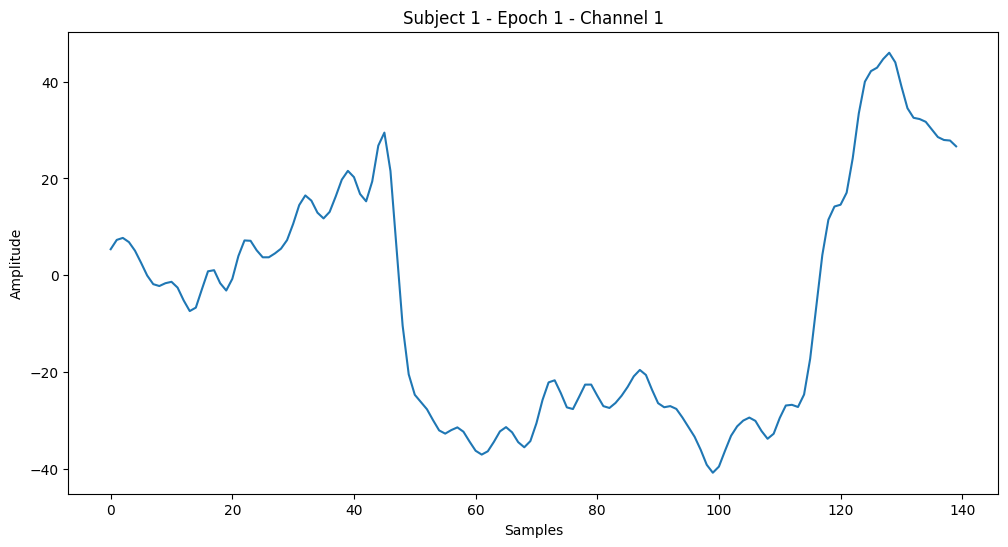

In [63]:
subject_to_plot = 1  # The first subject
epoch_to_plot = 1  # The first epoch
channel_to_plot = 1  # The first channel

plt.figure(figsize=(12, 6))
plt.plot(train_data_list[subject_to_plot, epoch_to_plot, channel_to_plot, :])
plt.title(f'Subject {subject_to_plot} - Epoch {epoch_to_plot} - Channel {channel_to_plot}')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

In [131]:
train_labels = pd.read_csv(r"C:\Users\Ashutosh Rabia\TrainLabels.csv")



In [65]:
n_subjects, n_epochs, n_channels, n_samples = train_data_list.shape


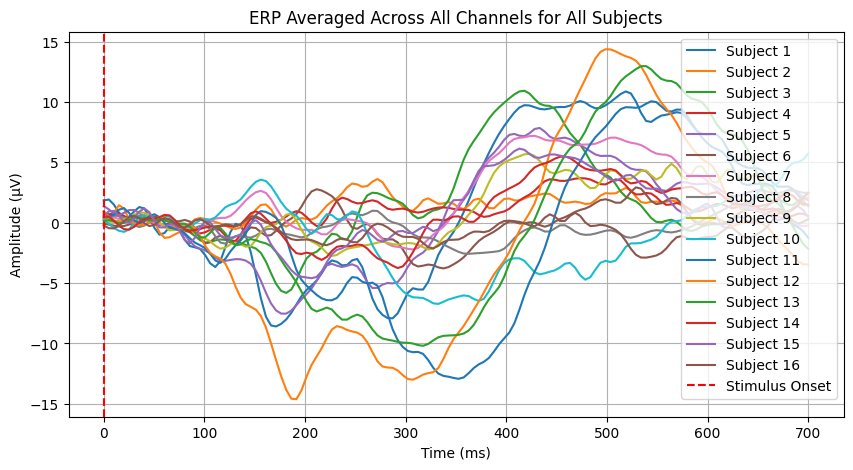

In [66]:
epoch_s = 0
epoch_e = 700
epoch_len = train_data_list.shape[-1]
time = np.linspace(epoch_s, epoch_e, epoch_len)

# Plot ERP for all subjects
plt.figure(figsize=(10, 5))
for subject_id in range(train_data_list.shape[0]):
    epochs = train_data_list[subject_id]
    
    # Average the signal across all channels
    average_epochs = np.mean(epochs, axis=1)

    # Calculate the ERP by averaging across all epochs
    erp = np.mean(average_epochs, axis=0)

    # Plot ERP for the current subject
    plt.plot(time, erp, label=f'Subject {subject_id + 1}')

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (µV)')
plt.title('ERP Averaged Across All Channels for All Subjects')
plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
plt.legend()
plt.grid(True)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


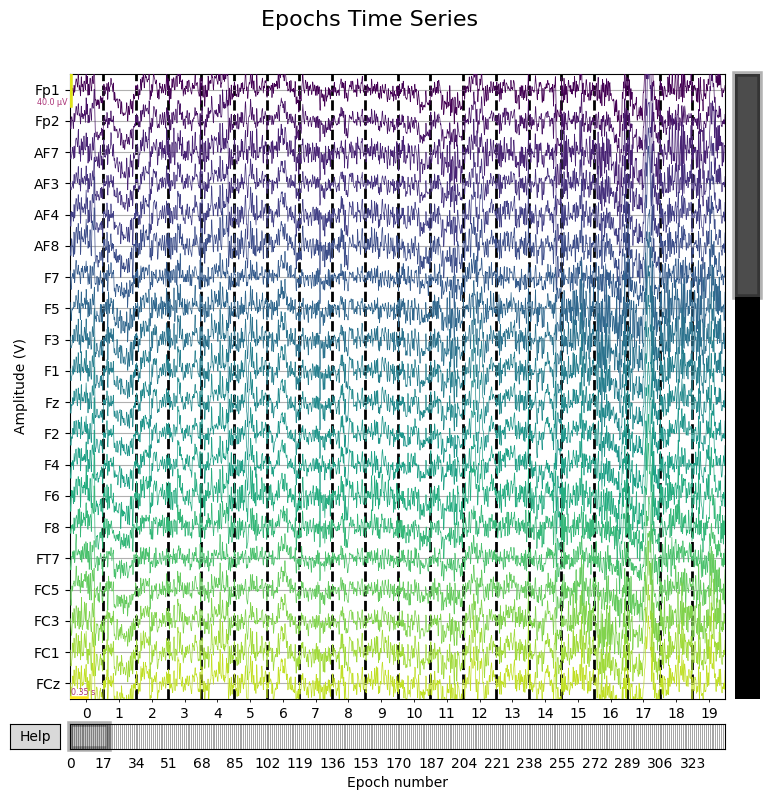

In [67]:
subject_id = 0
data = train_data_list[subject_id]  # Shape: (epochs, channels, times)

# Define the sampling rate
sampling_rate = 200  # in Hz

# Create info structure
ch_names = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
            'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
            'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
            'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
            'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
            'PO7', 'POz', 'PO8', 'O1', 'O2']
ch_types = ['eeg'] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# Convert data from microvolts to volts
epochs_data = data/1e6

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Plot the epochs as time series
fig = epochs.plot(show=False)  # Get the figure object

# Customize the plot
fig.subplots_adjust(top=0.9)  # Adjust the top margin to make room for the title
fig.suptitle('Epochs Time Series', fontsize=16)  # Add a title

# Customize colors
ax = fig.get_axes()[0]  # Get the first (and only) axes object
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0, 1, len(lines)))

for line, color in zip(lines, colors):
    line.set_color(color)

# Add grid and labels
ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (V)')

# Show the plot
plt.show()

In [68]:
data.shape


(340, 56, 140)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs...


C:\Users\Ashutosh Rabia\AppData\Local\Temp\ipykernel_17012\2092758398.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)
C:\Users\Ashutosh Rabia\AppData\Local\Temp\ipykernel_17012\2092758398.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)
C:\Users\Ashutosh Rabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


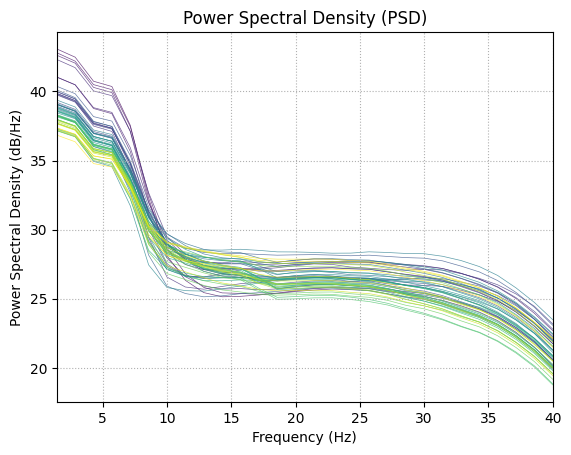

In [69]:
fig, ax = plt.subplots()
epochs.plot_psd(fmin=0.1, fmax=40.0, ax=ax)

# Customize the colors
lines = ax.get_lines()
colors = plt.cm.viridis(np.linspace(0, 1, len(lines)))

for line, color in zip(lines, colors):
    line.set_color(color)

# Add grid and labels
ax.grid(True)
ax.set_title('Power Spectral Density (PSD)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB/Hz)')

# Show the plot
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


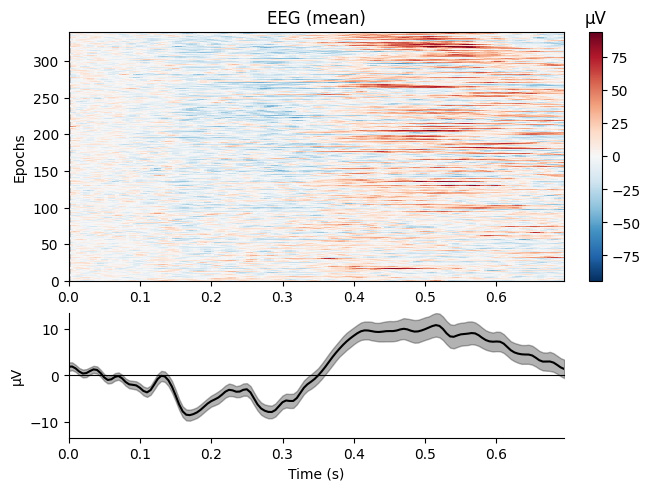

[<Figure size 640x480 with 3 Axes>]

In [70]:
epochs.plot_image(combine='mean')

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


C:\Users\Ashutosh Rabia\AppData\Local\Temp\ipykernel_17012\855489698.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])
C:\Users\Ashutosh Rabia\AppData\Local\Temp\ipykernel_17012\855489698.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])
C:\Users\Ashutosh Rabia\AppData\Local\Temp\ipykernel_17012\855489698.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])


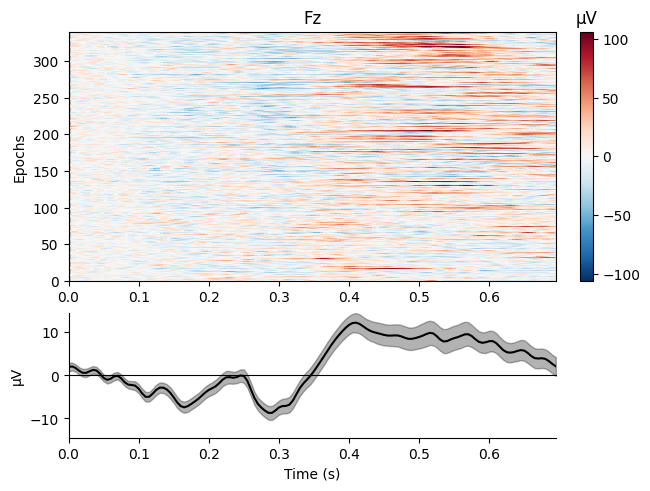

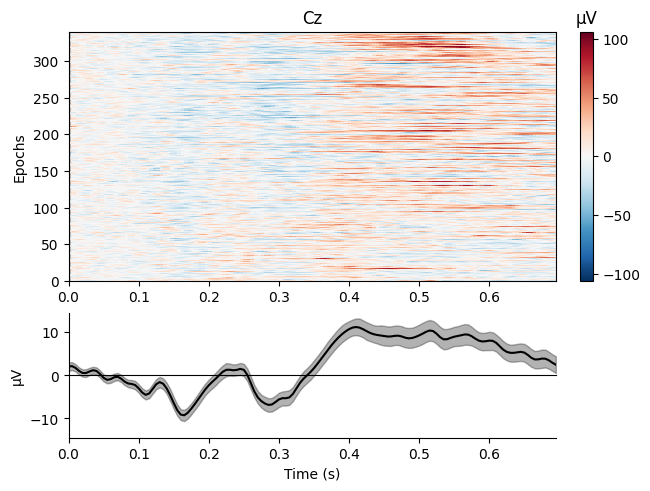

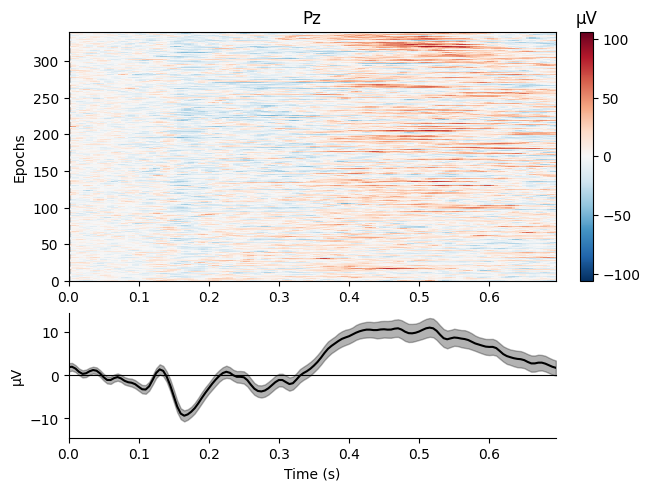

[<Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>,
 <Figure size 640x480 with 3 Axes>]

In [71]:
epochs["1"].plot_image(picks=["Fz", "Cz", "Pz"])

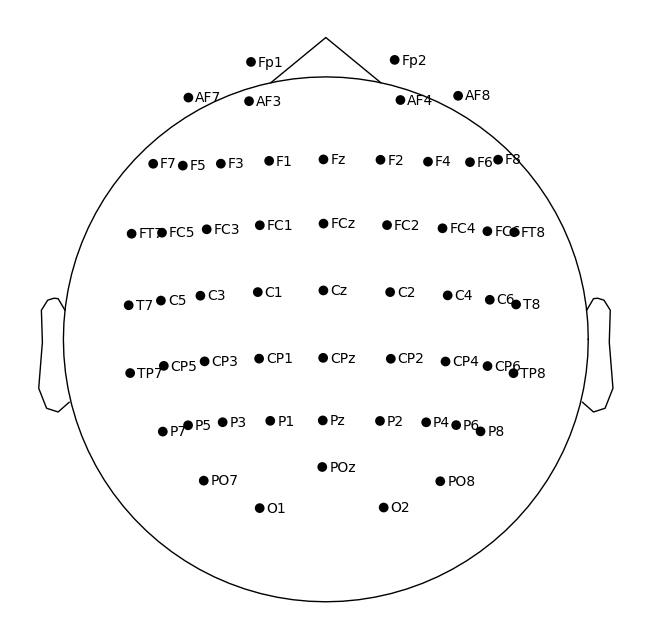

In [72]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)
fig = mne.viz.plot_sensors(info, kind='topomap', show_names=True, show=False)
plt.show()

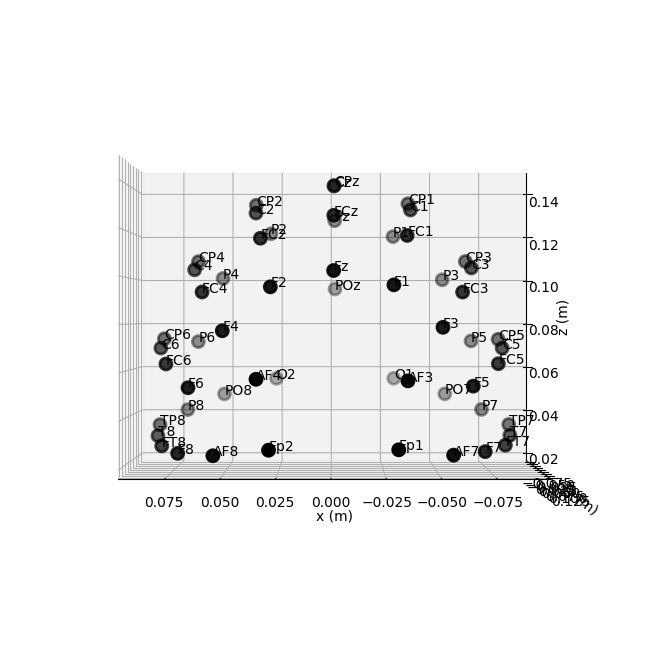

In [73]:
fig = mne.viz.plot_sensors(info, kind='3d', show_names=True, show=False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated


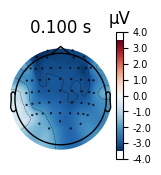

In [74]:
info = mne.create_info(ch_names=ch_names, sfreq=sampling_rate, ch_types=ch_types)

# Apply the standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Convert data from microvolts to volts
epochs_data = data / 1e6  # MNE expects data in volts

# Create events array, assuming each epoch is an event
events = np.array([[i, 0, 1] for i in range(epochs_data.shape[0])])

# Create MNE Epochs object
epochs = mne.EpochsArray(epochs_data, info, events)

# Compute the average of all epochs
evoked = epochs.average()

# Plot the topomap at a specific time point (e.g., 100 ms)
time_point = 0.1  # time in seconds
fig = evoked.plot_topomap(times=[time_point], ch_type='eeg', show = False)
plt.show()

In [93]:
## plotting signal traces ##


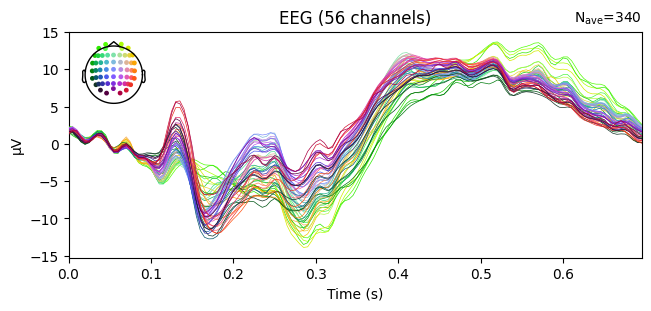

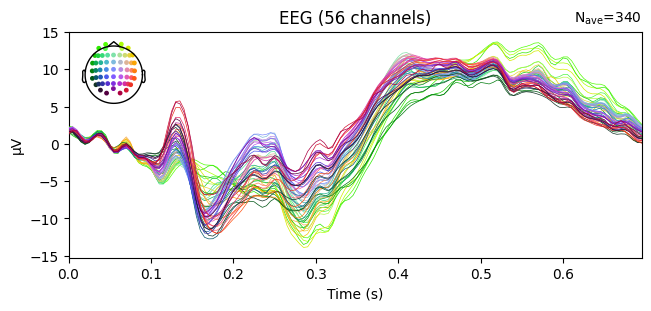

In [85]:
evoked.plot(exclude=[])

No projector specified for this dataset. Please consider the method self.add_proj.


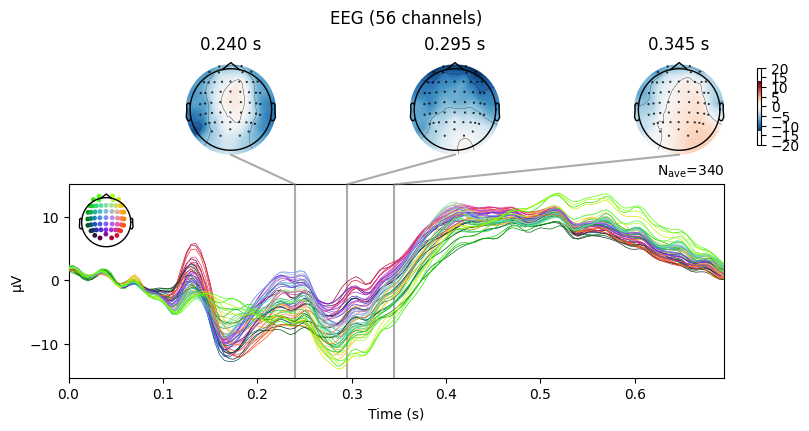

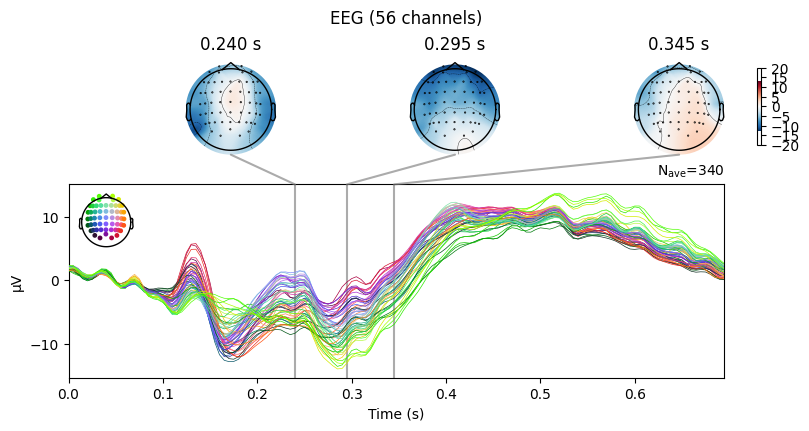

In [109]:
evoked.plot_joint()

combining channels using "mean"


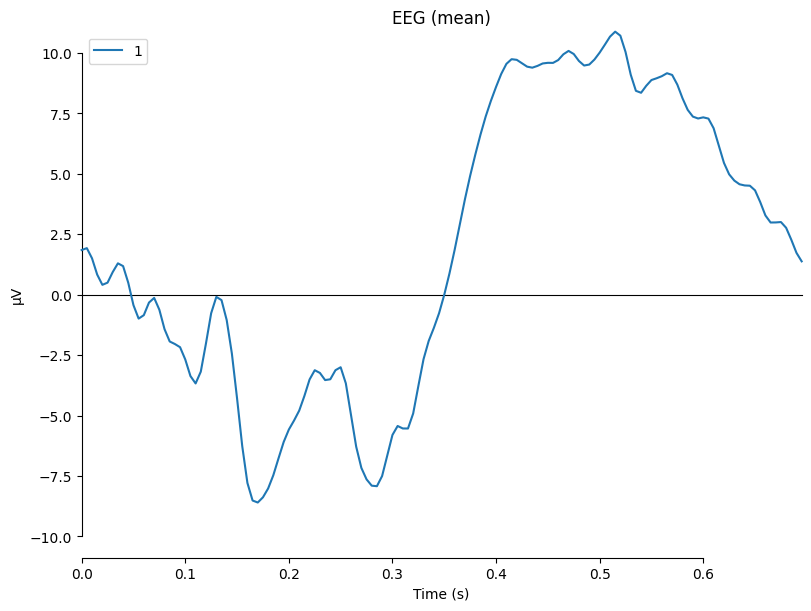

combining channels using "median"


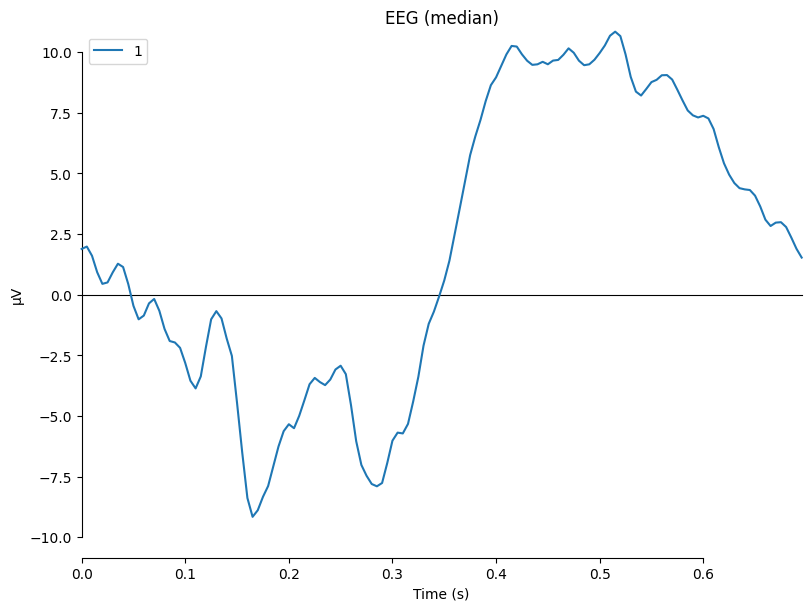

combining channels using GFP (eeg channels)


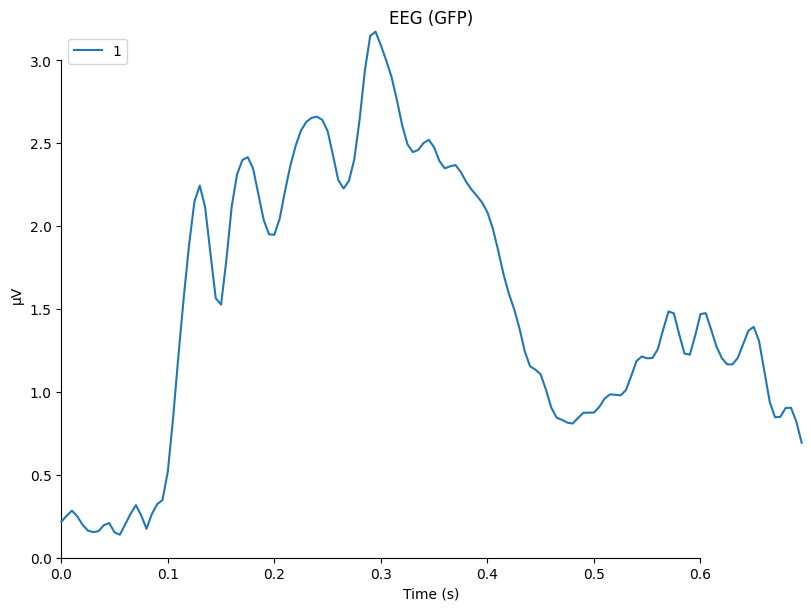

combining channels using "<function custom_func at 0x000002939D096DE0>"


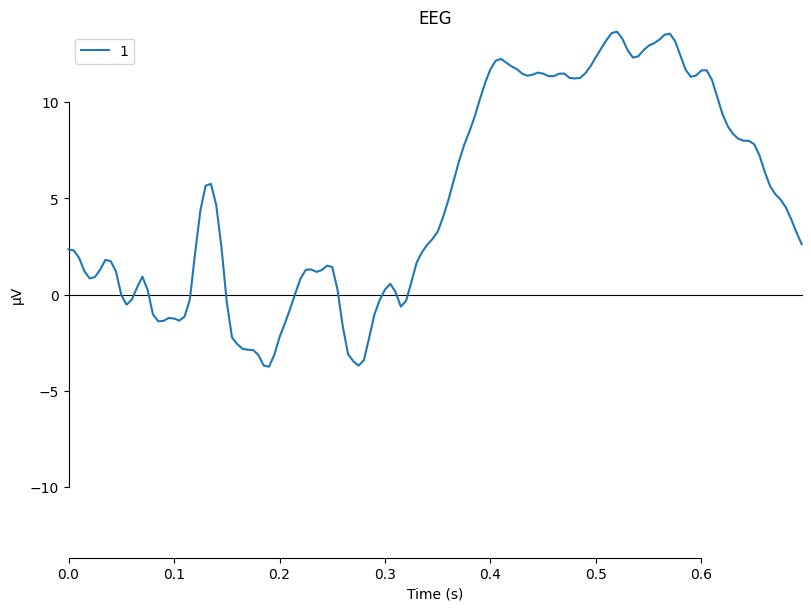

In [110]:
def custom_func(x):
    return x.max(axis=1)


for combine in ("mean", "median", "gfp", custom_func):
    mne.viz.plot_compare_evokeds(evoked, picks="eeg", combine=combine)

In [119]:
evoked

Condition,1
Data kind,average
Timepoints,140 samples
Channels,56 channels
Number of averaged epochs,340
Time range (secs),0.0 – 0.695
Baseline (secs),off


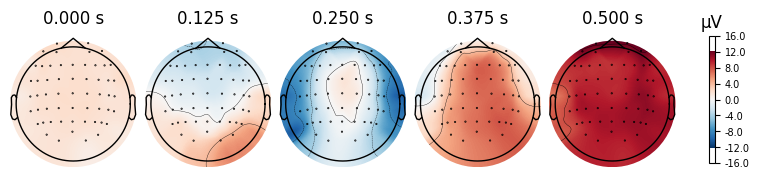

In [75]:
times = np.linspace(0, 0.5, 5)
fig = evoked.plot_topomap(times=times, ch_type='eeg', show = False)
plt.show()

Not setting metadata
340 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


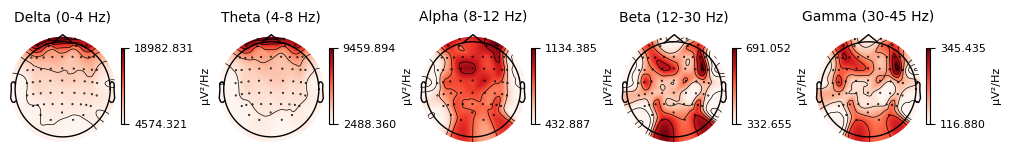

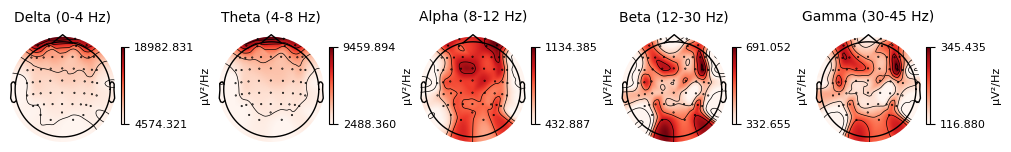

In [76]:
epochs = mne.EpochsArray(epochs_data, info, events)

spectrum = epochs.compute_psd()

spectrum.plot_topomap()

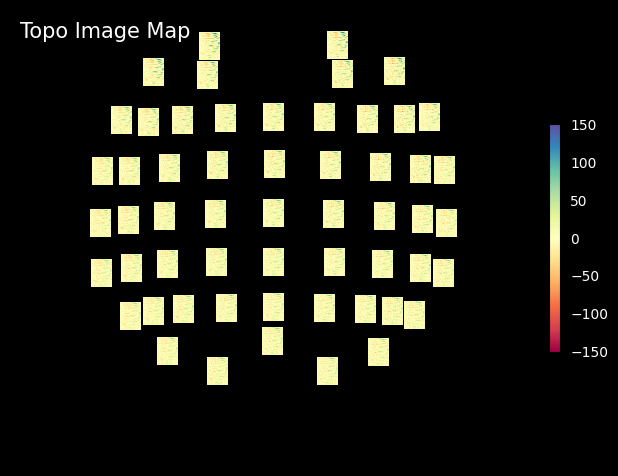

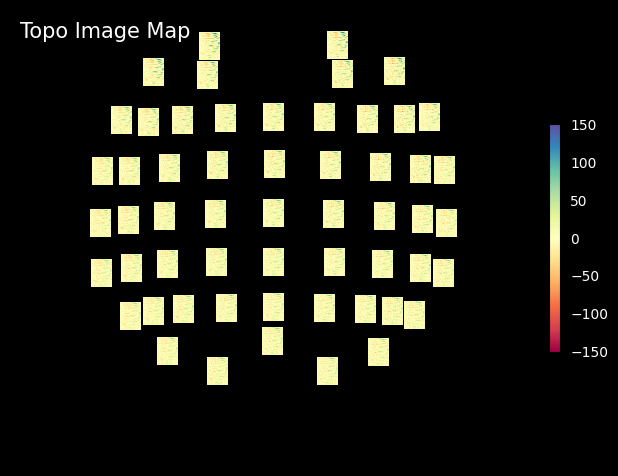

In [77]:
epochs.plot_topo_image(cmap='Spectral', title='Topo Image Map')

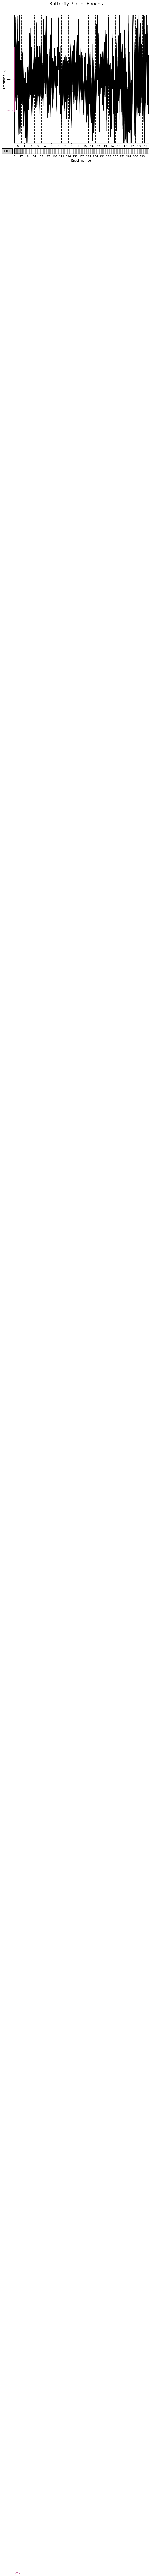

In [78]:
fig = epochs.plot(butterfly=True, scalings='auto', picks='all', show=False)

fig.subplots_adjust(top=0.9)
fig.suptitle('Butterfly Plot of Epochs', fontsize=16)

ax = fig.get_axes()[0]
lines = ax.get_lines()
colors = plt.cm.plasma(np.linspace(0, 1, len(lines)))

ax.grid(True)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (V)')

plt.show()